# Assignment 3: Evaluation

In this assignment you will implement various ranking metrics to evaluate rankings produced by three ranking systems.

We highly recommend that you use [Google Colab](https://colab.research.google.com/) for this assignment.


## 1. Download the QREL and result files
Start by downloading the QREL file and three result files:

In [1]:
!wget http://gem.cs.ru.nl/IR-Course/qrel.txt
!wget http://gem.cs.ru.nl/IR-Course/results_1.txt
!wget http://gem.cs.ru.nl/IR-Course/results_2.txt
!wget http://gem.cs.ru.nl/IR-Course/results_3.txt

--2023-09-30 11:27:35--  http://gem.cs.ru.nl/IR-Course/qrel.txt
Resolving gem.cs.ru.nl (gem.cs.ru.nl)... 131.174.31.31
Connecting to gem.cs.ru.nl (gem.cs.ru.nl)|131.174.31.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13164624 (13M) [text/plain]
Saving to: ‘qrel.txt’

qrel.txt            100%[===================>]  12.55M  7.05MB/s    in 1.8s    

2023-09-30 11:27:38 (7.05 MB/s) - ‘qrel.txt’ saved [13164624/13164624]

--2023-09-30 11:27:38--  http://gem.cs.ru.nl/IR-Course/results_1.txt
Resolving gem.cs.ru.nl (gem.cs.ru.nl)... 131.174.31.31
Connecting to gem.cs.ru.nl (gem.cs.ru.nl)|131.174.31.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22823425 (22M) [text/plain]
Saving to: ‘results_1.txt’

results_1.txt       100%[===================>]  21.77M  10.4MB/s    in 2.1s    

2023-09-30 11:27:40 (10.4 MB/s) - ‘results_1.txt’ saved [22823425/22823425]

--2023-09-30 11:27:40--  http://gem.cs.ru.nl/IR-Course/results_2.txt
Resolving ge

### Allowed Packages
For this assignment you are only allowed to use the following packages, you are **not allowed** to use any external existing implementations for reading QREL or results files or computing any of the evaluation metrics.

In [2]:
import json
import math
import numpy as np

## 2. Meet the data

### 2.1 The QREL file

The ground-truth containing query-document relevance judgments are provided in the qrel format, in the *qrel.txt* file.
From the official [TREC website](https://trec.nist.gov/data/qrels_noneng/) we get the following description of the format:
> The format of a qrels file is as follows:
>
> TOPIC       ITERATION       DOCUMENT#       RELEVANCY
>
> where TOPIC is the topic number,<br>
> ITERATION is the feedback iteration (almost always zero and not used),<br>
> DOCUMENT# is the official document number that corresponds to the "docno" field in the documents, and<br>
> RELEVANCY is a binary code of 0 for not relevant and 1 for relevant.
>
> Sample Qrels File:
>
> 1 0 AP880212-0161 0<br>
> 1 0 AP880216-0139 1<br>
> 1 0 AP880216-0169 0<br>
> 1 0 AP880217-0026 0<br>
> 1 0 AP880217-0030 0

For this assignment,
the TOPIC number will indicate a query ID number,
the ITERATION number can be ignored,
DOCUMENT# provides an identifier for the document required for referencing with the result files,
lastly RELEVANCY provides a binary number indicating relevancy with 0 for not relevant and 1 for relevant.

Each line in the file represents the placement of a single document-query combination.
Lines are ordered by query and thus can be parsed sequentially, the file starts with all documents for query 1 then 2, then 3 etc. Thus when query $N$ appears you can be sure that all of query $N-1$ has been parsed.

Let's take a look at the first 30 lines of the *qrel.txt* file.

In [3]:
with open('qrel.txt', 'r') as qrel_file:
    for _ in range(30):
        print(next(qrel_file)[:-1])

1 0 DOC9274 0 
2 0 DOC1294 0 
2 0 DOC3415 0 
2 0 DOC5402 0 
2 0 DOC6143 0 
2 0 DOC3598 0 
2 0 DOC0338 0 
2 0 DOC8272 0 
2 0 DOC1059 0 
2 0 DOC1525 0 
2 0 DOC8766 0 
2 0 DOC2631 0 
2 0 DOC4109 0 
2 0 DOC1427 0 
3 0 DOC5252 0 
3 0 DOC8461 0 
3 0 DOC1193 0 
3 0 DOC6223 0 
3 0 DOC0263 0 
4 0 DOC6139 0 
4 0 DOC6391 0 
4 0 DOC5583 0 
4 0 DOC5323 0 
4 0 DOC8838 0 
4 0 DOC6743 0 
4 0 DOC6527 0 
4 0 DOC0836 1 
5 0 DOC1966 0 
5 0 DOC9249 0 
5 0 DOC0923 1 


We see that for the first query DOC9274 is the only annotated document and it is not considered relevant.

Which documents are annotated per query is done via a pre-selection process. For the first query this resulted in a a single document, making it a *very* uninteresting query to rank for.

While most document-query combinations are not considered relevant, we see that for query 4, DOC0836 is relevant and also for query 5 DOC0923 is relevant.

### 2.2 The Results Files

The rankings which you will evaluate are provided in three files representing the output of three different ranking systems: *results_1.txt*, *results_2.txt* and *results_3.txt*.

In the last week's assignment you created similar result files yourself!

Again each line in the file represents a single query-document combination and is formatted as:
> TOPIC ITERATION DOCUMENT# RANK SCORE RUN#

For this assignment, the TOPIC number will indicate a query ID number, the ITERATION number can be ignored, DOCUMENT# provides an identifier for the document required for referencing with the QREL file, RANK indicates at what rank this document was placed for this query, SCORE is the score the ranking model gave to the query-document combination (higher scores are ranked first), and lastly RUN# provides an identifier for the specific ranking system used.

Let's take a look at the first 30 lines of the *results_1.txt* file.

In [4]:
with open('results_1.txt', 'r') as results_file:
    for _ in range(30):
        print(next(results_file)[:-1])

1 0 DOC9274 1 0.37270 RUN1 
2 0 DOC1294 8 0.37851 RUN1 
2 0 DOC3415 9 0.36128 RUN1 
2 0 DOC5402 5 0.39396 RUN1 
2 0 DOC6143 7 0.37981 RUN1 
2 0 DOC3598 6 0.38486 RUN1 
2 0 DOC0338 10 0.35127 RUN1 
2 0 DOC8272 12 0.34495 RUN1 
2 0 DOC1059 1 0.42166 RUN1 
2 0 DOC1525 2 0.41221 RUN1 
2 0 DOC8766 11 0.35098 RUN1 
2 0 DOC2631 3 0.39771 RUN1 
2 0 DOC4109 13 0.33992 RUN1 
2 0 DOC1427 4 0.39666 RUN1 
3 0 DOC5252 2 0.37440 RUN1 
3 0 DOC8461 1 0.39712 RUN1 
3 0 DOC1193 3 0.36817 RUN1 
3 0 DOC6223 5 0.35332 RUN1 
3 0 DOC0263 4 0.36205 RUN1 
4 0 DOC6139 5 0.37846 RUN1 
4 0 DOC6391 8 0.35296 RUN1 
4 0 DOC5583 4 0.38296 RUN1 
4 0 DOC5323 1 0.42094 RUN1 
4 0 DOC8838 2 0.40406 RUN1 
4 0 DOC6743 6 0.37418 RUN1 
4 0 DOC6527 7 0.36155 RUN1 
4 0 DOC0836 3 0.39487 RUN1 
5 0 DOC1966 7 0.41868 RUN1 
5 0 DOC9249 13 0.38231 RUN1 
5 0 DOC0923 5 0.42748 RUN1 


We see that for query 2 the first system provided the following ranking:
> DOC1059 DOC1525 DOC2631 DOC1427 DOC5402 DOC3598 DOC6143 DOC1294 DOC3415 DOC0338 DOC8766 DOC8272 DOC4109

For query 4 it has provided:
> DOC5323 DOC8838 DOC0836 DOC5583 DOC6743 DOC6527 DOC6391

Remember that in the QREL file, we saw that for query 4, DOC0836 was the only document annotated as relevant.
Therefore we know that, in this ranking for query 4, the only relevant document is at rank 3.

## 3. Processing the Files

### 3.1 Process a QREL Line
You will start by implementing a function that parses a single line from the QREL file and outputs the query ID, the document ID and the relevancy of the document to the query.

For instance, the following line:
>4 0 DOC0836 1

Should output the following tuple:
> (4, 'DOC0836', 1)

In [5]:
def parse_qrel_line(line):
    # =======Your code=======
    splitted_line = line.split()
    query = int(splitted_line[0])
    document = splitted_line[2]
    relevancy = int(splitted_line[3])
    # =======================
    return query, document, relevancy

The following assertions provide some test cases to verify your implementation:

In [6]:
assert parse_qrel_line('1 0 DOC0001 0')[0] == 1
assert parse_qrel_line('123 0 DOC0001 0')[0] == 123
assert parse_qrel_line('1 0 DOC0001 0')[1] == 'DOC0001'
assert parse_qrel_line('1 0 DOC1234 0')[1] == 'DOC1234'
assert parse_qrel_line('1 0 DOC1234 0')[2] == 0
assert parse_qrel_line('1 0 DOC1234 1')[2] == 1
assert type(parse_qrel_line('1 0 DOC0001 0')[0]) == int
assert type(parse_qrel_line('1 0 DOC0001 0')[2]) == int

### 3.2 Process a Result Line
Next implement a function that parses a single line from the results file and outputs the query ID, the document ID and the rank at which the document is placed by the ranking system.

For instance, the following line:
>2 0 DOC1294 8 0.37851 RUN1

Should output the following tuple:
> (2, 'DOC1294', 8)

In [7]:
def parse_results_line(line):
    # =======Your code=======
    splitted_line = line.split()
    query = int(splitted_line[0])
    document = splitted_line[2]
    rank = int(splitted_line[3])
    # =======================
    return query, document, rank

Again, here are several assertions to test your implementation:

In [8]:
assert parse_results_line('1 0 DOC0001 1 0.37270 RUN1')[0] == 1
assert parse_results_line('123 0 DOC0001 1 0.37270 RUN1')[0] == 123
assert parse_results_line('1 0 DOC0001 1 0.37270 RUN1')[1] == 'DOC0001'
assert parse_results_line('1 0 DOC1234 1 0.37270 RUN1')[1] == 'DOC1234'
assert parse_results_line('1 0 DOC1234 1 0.37270 RUN1')[2] == 1
assert parse_results_line('1 0 DOC1234 123 0.37270 RUN1')[2] == 123
assert type(parse_results_line('1 0 DOC0001 1 0.37270 RUN1')[0]) == int
assert type(parse_results_line('1 0 DOC0001 1 0.37270 RUN1')[2]) == int

### 3.3 Storing Document-Query Relevancies

In order to match the results and QREL files, it will be useful to have a lookup for the relevancies of document-query pairs according to the QREL file.

Complete the simple class below, so that you can quickly look up whether a document is relevant to a query or not.

*Hint: Use a dictionary of dictionary for `self.relevancies`; i.e., `{q1:{d1:r1, d2:r2, ...}, q2: {...}, ...}`*

In [9]:
class relevancy_lookup(object):
    def __init__(self):
        self.relevancies = {}

    def add(self, query, document, relevancy):
        # =======Your code=======
        if query in self.relevancies:
          self.relevancies[query].update({ document : relevancy })
        else:
          self.relevancies[query] = { document : relevancy }
        # =======================

    def get(self, query, document):
        # =======Your code=======
        if query in self.relevancies and document in self.relevancies[query]:
          return self.relevancies[query][document]
        return None
        # =======================

The code below will store the relevancy of two documents w.r.t. two queries and then verify whether they were stored correctly.

In [10]:
test_lookup = relevancy_lookup()
test_lookup.add(1, 'DOC0001', 1)
test_lookup.add(2, 'DOC0001', 0)
test_lookup.add(1, 'DOC1234', 0)
test_lookup.add(2, 'DOC1234', 1)
assert test_lookup.get(1, 'DOC0001') == 1
assert test_lookup.get(2, 'DOC0001') == 0
assert test_lookup.get(1, 'DOC1234') == 0
assert test_lookup.get(2, 'DOC1234') == 1
assert type(test_lookup.get(1, 'DOC0001')) == int

### 3.4 Matching Relevancy Labels with Results Rankings

In order to compute IR metrics, we need to know at what ranks relevant documents where placed per query.

This function takes as input, a *relevancy_lookup* as implemented above, a query ID number, and a list of documents and ranks, and as output it gives a numpy vector of relevancies, indicating the ranked labels.

For example, *doc_rank_list* could be:
> [('DOC0001', 1), ('DOC0002', 3), ('DOC0003', 2)]

Indicating that DOC0001 is placed at rank 1, DOC0003 at rank 2 and DOC0002 at rank 3, i.e. the ranking:
> [DOC0001, DOC0003, DOC0002]

If DOC0001 and DOC0003 are relevant but DOC0002 is not then the output of the function should be:
>[1,1,0]

(stored as a numpy array).

In [11]:
def get_ranked_labels(rel_lookup, query, doc_rank_list):
    result = np.zeros(len(doc_rank_list), dtype=int)
    for x in doc_rank_list:
        result[x[1]-1] = rel_lookup.get(query, x[0])
    return result

### 3.5 Processing the QREL and Results Files

Finally, it is time to combine the functions you have implemented above to process both the QREL and a result file at once.

The function below will take as input a path to a QREL file and a results file and output the ranked labels as an iterable.
This means that we can use this function in a for loop to easily iterate over all metrics.

In [12]:
def process_files(qrel_path, results_path):
    relevancies = relevancy_lookup()
    with open(qrel_path, 'r') as qrel_file:
        for line in qrel_file:
            query, document, relevancy = parse_qrel_line(line)
            relevancies.add(query, document, relevancy)
    with open(results_path, 'r') as results_file:
        current_query, document, rank = parse_results_line(next(results_file))
        doc_rank_list = [(document, rank)]
        for line in results_file:
            query, document, rank = parse_results_line(line)
            if query != current_query:
                yield get_ranked_labels(relevancies, current_query, doc_rank_list)
                current_query = query
                doc_rank_list = [(document, rank)]
            else:
                doc_rank_list.append((document, rank))
        yield get_ranked_labels(relevancies, current_query, doc_rank_list)

For example, the code below should print the ranked labels for the first five queries (if you implemented the code in 3.1-3.3 correctly).

In [13]:
counter = 5
for x in process_files('qrel.txt', 'results_1.txt'):
    print(x)
    counter = counter - 1
    if counter == 0:
        break

[0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0]
[0 0 1 0 0 0 0 0]
[0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0]


As a check, the code below will go over all queries, you should be able to run this code without error and in less than a minute.

In [14]:
for _ in process_files('qrel.txt', 'results_1.txt'):
    pass

## 4. Evaluation Metrics

For this assignment, you will implement seven different ranking metrics.
To keep descriptions exact we will provide formulas for the metric values for a single query, less formal descriptions can be found in the lecture slides.

We will use the following notation:

$K$ is the number of top results the metric considers, i.e. Precision@3 only looks at the top 3 results in the ranking, $r(q, i)$ indicates the label for the document ranked at position $i$ for query $q$ and  $D_q$ is the number of documents pre-selected for query $q$.

Per query all the pre-selected documents are given in the result files so you do not have to consider the possibility of missing documents.

Some queries will have less pre-selected documents than $K$ (e.g. query 1 only has one preselected document!), for this assignment, you should treat *no document* (missing documents) as a non-relevant document, i.e. $i > D_q \rightarrow r(q, i) = 0$.

If there are no relevant pre-selected documents for a query at all, all metric values are 0, this avoids any divisions by zero you may encounter.

The metrics to implement are:
1. The Precision metric:
$$\text{Precision}@K(q) = \frac{1}{K} \sum_{i=1}^K r(q, i).$$

2. The Recall metric:
$$\text{Recall}@K(q) = \frac{\sum_{i=1}^K r(q, i)}{\sum_{j=1}^{D_q} r(q, j)}.$$

3. The F-Score metric using the harmonic mean (a.k.a. the F-Measure):
$$\text{F-Score}@K(q) =  \frac{2 \cdot \text{Precision}@K \cdot \text{Recall}@K}{\left(\text{Precision}@K + \text{Recall}@K\right)}.$$

4. Discounted Cumulative Gain (DCG):
$$
\text{DCG}@K(q) = \sum_{i=1}^{\min(K, D_q)} \frac{r(q, i)}{\log_2(1+i)}.
$$

5. Normalized Discounted Cumulative Gain (NDCG) which is normalized by the Ideal DCG (IDCG), i.e. the maximum possible DCG value for the query:
$$
\text{NDCG}@K(q) = \frac{\text{DCG}@K(q)}{\text{IDCG}@K(q)}.
$$

6. The Average Precision (AP) which is based on the query-level Average Precision:
$$
\text{Average-Precision}(q) = \frac{\sum_{k=1}^{D_q} r(q, k) \cdot \text{Precision}@k(q) }{\sum_{i=1}^{D_q} r(q, i)}.
$$

7. The Reciprocal Rank (RR) which is based on the query-level Reciprocal Rank:
$$
\text{Reciprocal Rank}(q) = \frac{1}{\min\{i : r(q,i) = 1\}}.
$$

**Note that when we take the avergae of AP and RR over all queries, we call the metrics Mean Average Precision (MAP) and Mean Reciprocal Rank (MRR), respectively.**

## 5. Implement the Evaluation Metrics

You will now implement each of these metrics, we have provided test cases for precision and recommend that you create your own tests for the other metrics.

Section 6 will verify your implementation on one result file, you can use this as a strong correctness test of your implementation.

We recommend using [basic Numpy operations](https://numpy.org/doc/stable/user/quickstart.html#basic-operations) to perform most math operations.

### 5.1 Precision

Implement the precision function below, the input is a numpy array of relevancies (i.e. [0,1,0,0,0]) and k, the number of top results the metric considers.

In [15]:
def precision(query_relevancy_labels, k):
    # =======Your code=======
    return (1/k)*sum(query_relevancy_labels[:k])
    # =======================

The tests below check your implementation on various example cases, note that we use [np.isclose](https://numpy.org/doc/stable/reference/generated/numpy.isclose.html) to do the [float comparisons](https://en.wikipedia.org/wiki/Round-off_error).

In [16]:
assert np.isclose(precision(np.array([0,0,0,0,0], dtype=int), 5), 0)
assert np.isclose(precision(np.array([0,0,0,0,1], dtype=int), 5), 0.2)
assert np.isclose(precision(np.array([0,0,0,0,1], dtype=int), 4), 0)
assert np.isclose(precision(np.array([1,1,1,1,0], dtype=int), 4), 1)
assert np.isclose(precision(np.array([1,1,1,1,1], dtype=int), 4), 1)
assert np.isclose(precision(np.array([0,1,1,1,1], dtype=int), 4), 0.75)
assert np.isclose(precision(np.array([0,0,1,1,1], dtype=int), 3), 0.333333333333333)
assert np.isclose(precision(np.array([0], dtype=int), 5), 0)
assert np.isclose(precision(np.array([1], dtype=int), 5), 0.2)
assert np.isclose(precision(np.array([0, 1], dtype=int), 5), 0.2)

### 5.2 Recall

In [17]:
def recall(query_relevancy_labels, k):
    # =======Your code=======
    denominator = sum(query_relevancy_labels)
    if denominator == 0:
      return 0
    return sum(query_relevancy_labels[:k])/denominator
    # =======================

In [18]:
# Test your code
assert np.isclose(recall(np.array([0,0,0,0,0], dtype=int), 5), 0)
assert np.isclose(recall(np.array([0,0,0,0,1], dtype=int), 5), 1)
assert np.isclose(recall(np.array([0,0,0,0,1], dtype=int), 4), 0)
assert np.isclose(recall(np.array([1,1,1,1,0], dtype=int), 4), 1)
assert np.isclose(recall(np.array([1,1,1,1,1], dtype=int), 4), 0.8)
assert np.isclose(recall(np.array([0,1,1,1,1], dtype=int), 4), 0.75)
assert np.isclose(recall(np.array([0,0,1,1,1], dtype=int), 3), 0.333333333333333)
assert np.isclose(recall(np.array([0], dtype=int), 5), 0)
assert np.isclose(recall(np.array([1], dtype=int), 5), 1)
assert np.isclose(recall(np.array([0, 1], dtype=int), 5), 1)

### 5.3 F-Score

In [19]:
def F_score(query_relevancy_labels, k):
    # =======Your code=======
    p = precision(query_relevancy_labels, k)
    r = recall(query_relevancy_labels, k)
    denominator = p + r
    if denominator == 0 :
      return 0
    return (2 * p * r) / denominator
    # =======================

In [20]:
# Test your code
assert np.isclose(F_score(np.array([0,0,0,0,0], dtype=int), 5), 0)
assert np.isclose(F_score(np.array([0,0,0,0,1], dtype=int), 5), 0.33333333333333337)


### 5.4 Discounted Cumulative Gain

In [21]:
def DCG(query_relevancy_labels, k):
    # Use log with base 2
    # =======Your code=======
    min_sum = min(k,len(query_relevancy_labels))
    i = np.arange(1,min_sum+1)
    return sum(query_relevancy_labels[i-1]/np.log2(i+1))
    # =======================

In [22]:
# Test your code
assert np.isclose(DCG(np.array([0,0,0,0,0], dtype=int), 5), 0)
assert np.isclose(DCG(np.array([0,0,0,0,1], dtype=int), 5), 0.38685280723454163)
assert np.isclose(DCG(np.array([0,1,1,1,1], dtype=int), 4), 1.5616063116448506)
assert np.isclose(DCG(np.array([0,0,1,1,1], dtype=int), 3), 0.5)
assert np.isclose(DCG(np.array([0], dtype=int), 5), 0)
assert np.isclose(DCG(np.array([1], dtype=int), 5), 1)
assert np.isclose(DCG(np.array([0, 1], dtype=int), 5), 0.6309297535714575)

### 5.5 Normalized Discounted Cumulative Gain

In [23]:
def NDCG(query_relevancy_labels, k):
    # =======Your code=======
    # get the relevance score map sorting by descending order
    relevance_scores_ideal = np.sort(query_relevancy_labels)[::-1]
    denominator = DCG(relevance_scores_ideal, k)
    if denominator == 0:
      return 0
    return DCG(query_relevancy_labels, k) / denominator
    # =======================

In [24]:
# Test your code
assert np.isclose(NDCG(np.array([0,0,0,0,0], dtype=int), 5), 0)
assert np.isclose(NDCG(np.array([0,0,0,0,1], dtype=int), 5), 0.38685280723454163)
assert np.isclose(NDCG(np.array([0,1,1,1,1], dtype=int), 4), 0.6096199500078984)
assert np.isclose(NDCG(np.array([0, 1], dtype=int), 5), 0.6309297535714575)

### 5.6 Average Precision

In [25]:
def AP(query_relevancy_labels):
    # =======Your code=======
    denominator = np.sum(query_relevancy_labels)
    if denominator == 0:
      return 0
    iterator = np.arange(1,len(query_relevancy_labels)+1)
    return sum(query_relevancy_labels[i-1]*precision(query_relevancy_labels,i) for i in iterator) / denominator
    # =======================

In [26]:
# Test your code
assert np.isclose(AP(np.array([0,0,0,0,0], dtype=int)), 0)
assert np.isclose(AP(np.array([0,0,0,0,1], dtype=int)), 0.2)
assert np.isclose(AP(np.array([0,1,1,1,1], dtype=int)), 0.6791666666666667)
assert np.isclose(AP(np.array([1], dtype=int)), 1)
assert np.isclose(AP(np.array([0, 1], dtype=int)), 0.5)

### 5.7 Reciprocal Rank

In [27]:
def RR(query_relevancy_labels):
    # =======Your code=======
    indices = np.asarray(np.where(query_relevancy_labels==1)) + 1
    # make the array from 2d to 1d
    indices = indices.flatten()
    if indices.size == 0:
      return 0
    denominator = min(indices)
    return 1/denominator
    # =======================

In [28]:
assert np.isclose(RR(np.array([0,0,0,0,0], dtype=int)), 0)
assert np.isclose(RR(np.array([0,0,0,0,1], dtype=int)), 0.2)
assert np.isclose(RR(np.array([0,1,1,1,1], dtype=int)), 0.5)
assert np.isclose(RR(np.array([1], dtype=int)), 1)
assert np.isclose(RR(np.array([0, 0, 1], dtype=int)), 0.3333333333333333)

## 6. Processing an Entire Results File

Now that you have implementations for each of the metrics, we can compute their mean values averaged over all the queries in dataset.

### 6.1 Computing Metric Means over an Entire Results File

The following code will go over all queries in the files, compute the metric values and average them, it makes use of your implementation of the *process_files* function.

In [29]:
def evaluate(qrel_path, results_path):
    results_per_query = {
        'precision@1': [],
        'precision@5': [],
        'precision@10': [],
        'precision@25': [],
        'recall@1': [],
        'recall@5': [],
        'recall@10': [],
        'recall@25': [],
        'F-score@1': [],
        'F-score@5': [],
        'F-score@10': [],
        'F-score@25': [],
        'DCG@1': [],
        'DCG@5': [],
        'DCG@10': [],
        'DCG@25': [],
        'NDCG@1': [],
        'NDCG@5': [],
        'NDCG@10': [],
        'NDCG@25': [],
        'MAP': [],
        'MRR': [],
    }
    for labels in process_files(qrel_path, results_path):
        results_per_query['precision@1'].append(precision(labels, 1))
        results_per_query['precision@5'].append(precision(labels, 5))
        results_per_query['precision@10'].append(precision(labels, 10))
        results_per_query['precision@25'].append(precision(labels, 25))
        results_per_query['recall@1'].append(recall(labels, 1))
        results_per_query['recall@5'].append(recall(labels, 5))
        results_per_query['recall@10'].append(recall(labels, 10))
        results_per_query['recall@25'].append(recall(labels, 25))
        results_per_query['F-score@1'].append(F_score(labels, 1))
        results_per_query['F-score@5'].append(F_score(labels, 5))
        results_per_query['F-score@10'].append(F_score(labels, 10))
        results_per_query['F-score@25'].append(F_score(labels, 25))
        results_per_query['DCG@1'].append(DCG(labels, 1))
        results_per_query['DCG@5'].append(DCG(labels, 5))
        results_per_query['DCG@10'].append(DCG(labels, 10))
        results_per_query['DCG@25'].append(DCG(labels, 25))
        results_per_query['NDCG@1'].append(NDCG(labels, 1))
        results_per_query['NDCG@5'].append(NDCG(labels, 5))
        results_per_query['NDCG@10'].append(NDCG(labels, 10))
        results_per_query['NDCG@25'].append(NDCG(labels, 25))
        results_per_query['MAP'].append(AP(labels))
        results_per_query['MRR'].append(RR(labels))

    results = {}
    for key, values in results_per_query.items():
        results[key] = np.mean(values)
    return results

### 6.2 Checking Part of Your Answer
To make the process easier for you, we have provided you with the correct metrics for the first results file.

Remember that when grading we will look at the computed metrics for **all three** result files: therefore passing this check does not guarantee that the assignment was done correctly.
However, if this check is not passed you can be certain that your answer needs improvement.

In [30]:
correct_answers = {
    'precision@1': 0.4513313110886417,
    'precision@5': 0.4228985507246377,
    'precision@10': 0.3832895180316819,
    'precision@25': 0.2720552746882373,
    'recall@1': 0.07472577850117126,
    'recall@5': 0.315725702455326,
    'recall@10': 0.5169225080207952,
    'recall@25': 0.7482686903944814,
    'F-score@1': 0.11454143750486454,
    'F-score@5': 0.30638131785149253,
    'F-score@10': 0.37767235358763745,
    'F-score@25': 0.35247610330560825,
    'DCG@1': 0.4513313110886417,
    'DCG@5': 1.2656562772756248,
    'DCG@10': 1.8173462254841932,
    'DCG@25': 2.5379411534956744,
    'NDCG@1': 0.4513313110886417,
    'NDCG@5': 0.4720439629436193,
    'NDCG@10': 0.520432656270525,
    'NDCG@25': 0.5958868199120942,
    'MAP': 0.4969908565132953,
    'MRR': 0.5849835056944714
    }
your_answers = evaluate('qrel.txt', 'results_1.txt')
print('CORRECTNESS METRIC-NAME    CORRECT  YOURS   ERROR')
print('--------------------------------------------------')
for metric_name in correct_answers:
    correct_a = correct_answers[metric_name]
    your_a =  your_answers[metric_name]
    error = (correct_a - your_a)
    acceptable = np.abs(error) < 0.0001
    output_tuple = (metric_name.ljust(14), correct_a, your_a, error)
    if acceptable:
        print('ACCEPTABLE  %s %0.05f %0.05f %0.05f' % output_tuple)
    else:
        print('INCORRECT   %s %0.5f %0.05f %0.05f' % output_tuple)

CORRECTNESS METRIC-NAME    CORRECT  YOURS   ERROR
--------------------------------------------------
ACCEPTABLE  precision@1    0.45133 0.45133 0.00000
ACCEPTABLE  precision@5    0.42290 0.42290 0.00000
ACCEPTABLE  precision@10   0.38329 0.38329 0.00000
ACCEPTABLE  precision@25   0.27206 0.27206 0.00000
ACCEPTABLE  recall@1       0.07473 0.07473 0.00000
ACCEPTABLE  recall@5       0.31573 0.31573 0.00000
ACCEPTABLE  recall@10      0.51692 0.51692 0.00000
ACCEPTABLE  recall@25      0.74827 0.74827 0.00000
ACCEPTABLE  F-score@1      0.11454 0.11454 0.00000
ACCEPTABLE  F-score@5      0.30638 0.30638 0.00000
ACCEPTABLE  F-score@10     0.37767 0.37767 -0.00000
ACCEPTABLE  F-score@25     0.35248 0.35248 0.00000
ACCEPTABLE  DCG@1          0.45133 0.45133 0.00000
ACCEPTABLE  DCG@5          1.26566 1.26566 0.00000
ACCEPTABLE  DCG@10         1.81735 1.81735 0.00000
ACCEPTABLE  DCG@25         2.53794 2.53794 0.00000
ACCEPTABLE  NDCG@1         0.45133 0.45133 0.00000
ACCEPTABLE  NDCG@5         0.47

## 7. Processing All Result Files and Handing In

### 7.1 Evaluating and Outputting

The following code will generate the files for you to hand in, update the *student* variables and run it.

In [31]:
student_number = 's1122141'
student_first_name = 'FOTEINI'
student_last_name = 'PAPADOPOULOU'

result = {
    'STUDENTNUMBER': student_number,
    'FIRSTNAME': student_first_name,
    'LASTNAME': student_last_name,
    'results_1': evaluate('qrel.txt', 'results_1.txt'),
    'results_2': evaluate('qrel.txt', 'results_2.txt'),
    'results_3': evaluate('qrel.txt', 'results_3.txt'),
}

output_path = '%s_%s_%s_evaluation_assignment.json' % (student_number, student_first_name, student_last_name)
with open(output_path, 'w') as f:
      json.dump(result, f)

### 7.2 Reflection

Take a look at the metrics for the three results files in the json file you have just created, what observations do you make? are there conclusions we can make from these observations?<br>
*(max 300 words)*

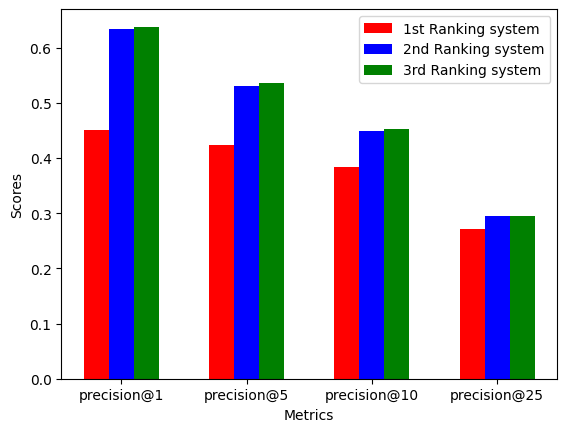

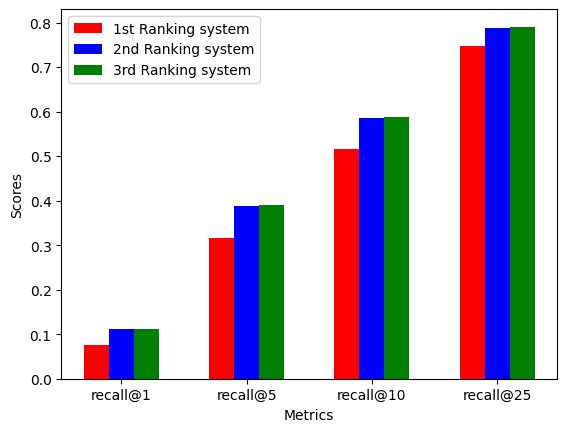

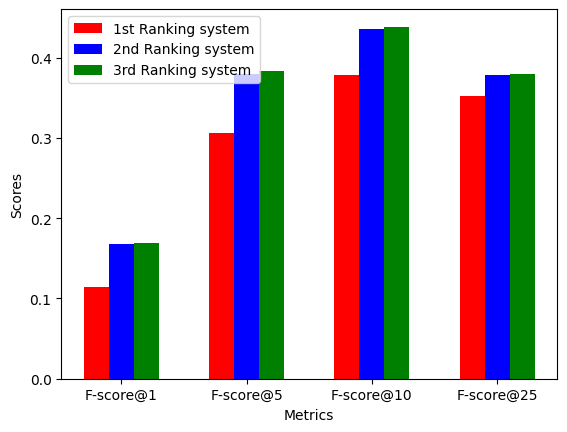

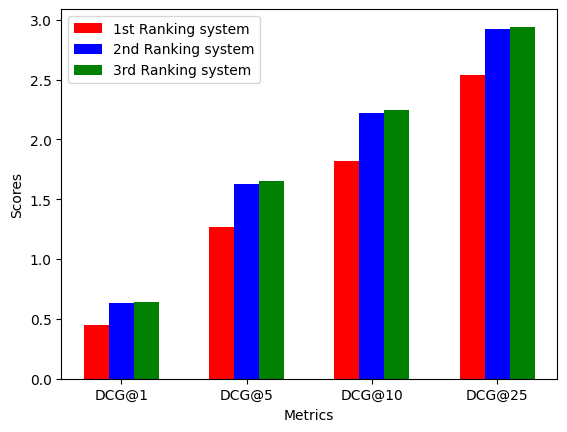

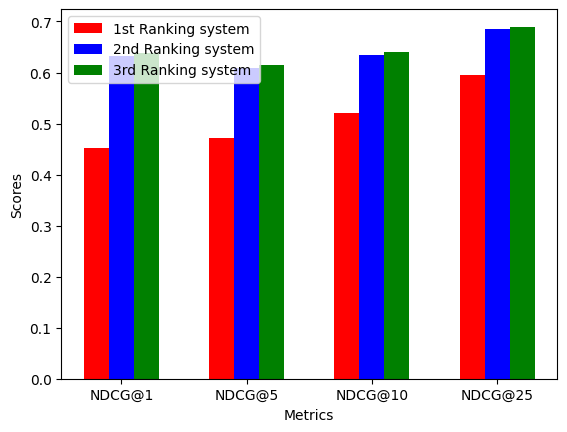

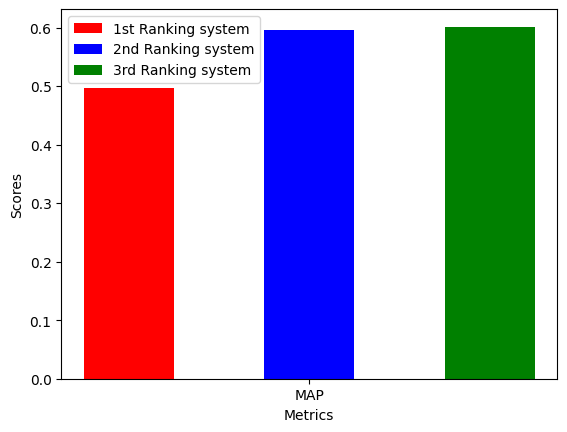

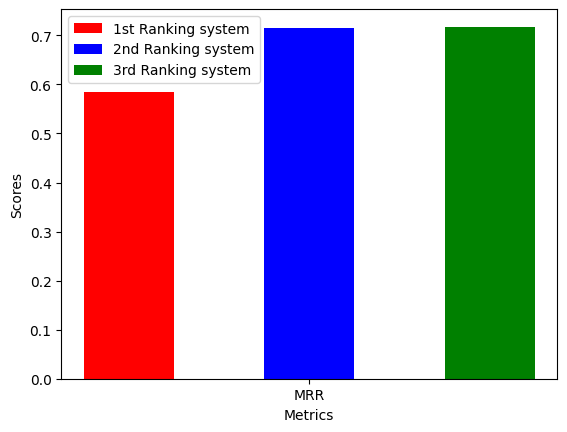

In [32]:
import matplotlib.pyplot as plt

def plot_metrics(metric_str,x_number = 4):
  if x_number == 4:
    # Case for precision,recall,f1,dcg,ndcg
    x = np.arange(4)
    keys = [f'{metric_str}@1', f'{metric_str}@5', f'{metric_str}@10', f'{metric_str}@25']
    width = 0.2
  else:
    # Case for map,mrr
    x = np.arange(1)
    width = 0.1
    keys = [f'{metric_str}']
  r1 = [result['results_1'][key] for key in keys]
  r2 = [result['results_2'][key] for key in keys]
  r3 = [result['results_3'][key] for key in keys]


  plt.bar(x-0.2, r1, width, color='red')
  plt.bar(x, r2, width, color='blue')
  plt.bar(x+0.2, r3, width, color='green')
  plt.xticks(x,keys)
  plt.xlabel("Metrics")
  plt.ylabel("Scores")
  plt.legend(['1st Ranking system', '2nd Ranking system', '3rd Ranking system'])
  plt.show()
plot_metrics("precision")
plot_metrics("recall")
plot_metrics("F-score")
plot_metrics("DCG")
plot_metrics("NDCG")
plot_metrics("MAP",1)
plot_metrics("MRR",1)

In order to make the observations prominent and compare the results of each ranking system, I have plotted all the metrics on each figure as bars. As can be seen clearly, the 1st ranking system has the lowest score in all metrics, while the 2nd and the 3rd systems have the same approximate behavior. First of all, regarding the precision metric at top results 1,5,10, and 25, for all the ranking systems it seems to decline steadily as the top results increase. On the other hand, the recall metric rises at each top result and for each of the three ranking systems, with the third one being slightly better than the second one. The F1 metric, which combines the precision and recall scores, seems that it follows an upward trend for all the three system rankings, and then after the top 10 results, it declines for the top 25 results. It is important to mention that the F1 score is low when either precision or recall is extremely high(e.g. on the top 1 result). Moreover, the discounted cumulative gain metric increases steadily for each ranking system, and we include more top results, whereas, for the normalized discounted cumulative gain, which compares the discounted cumulative gain across different queries, appears that for the 2nd and 3rd ranking systems is approximately the same for top 1,5,10 results and for the top 25 results a slight rise, but for the 1st system as the top result increase, it grows up too. Lastly, the mean average precision is roughly the same for the 2nd and the 3rd ranking systems(0.59,0.6), while for the 1st ranking system is 0.49, and the mean reciprocal rank follows the same pattern as the mean average precision for all the ranking systems. Overall, the 2nd and 3rd systems have better scores in all metrics, while the 1st system has  a low score in all cases of metrics.

### 7.3 Handing in

Hand in the json output file, the filled in notebook, and the converted notebook to **PDF format**.  Rename your files to:
> STUDENTNUMBER_FIRSTNAME_LASTNAME_evaluation.ipynb
> STUDENTNUMBER_FIRSTNAME_LASTNAME_evaluation.pdf
> STUDENTNUMBER_FIRSTNAME_LASTNAME_evaluation_assignment.json